In [1]:
import pkg_resources
from pkg_resources import DistributionNotFound, VersionConflict
from platform import python_version
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import numpy as np 
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sns 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from numpy import arange
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date
import random
today = str(date.today())

In [2]:
random.seed(20)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
def run_models(metric, pos, save):
    
    print('Pulling data')

    metric_clean = metric

    if metric == 'Avg':
        
        metric = 'Avg_Points'
        
        # join to get avg points
        points_df = pd.read_csv("/content/gdrive/MyDrive/DVA Project/Data/player_plus_team.csv")
        points = points_df['Avg_PPRFantasyPoints']
        points_players = points_df.iloc[:, 1:5]
        points_players['Avg_Points'] = points
        
        # Read in Data
        data_original = pd.read_excel("/content/gdrive/MyDrive/DVA Project/Data/Pivoted_Data/pivoted_player_plus_team_data_ZEROS_Resp.xlsx")
        
        # Join with Data
        data_full = data_original.merge(points_players, left_on=['Player','Current_Year','Pos', 'Max_Team_Name'], right_on=['Player','Year','Pos', 'Team_Name'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
        data_full = data_full.drop(columns={'RESPONSE_Sum_PPRFantasyPoints', 'Team_Name', 'Year'}, axis=1)
        data_full = data_full[data_full['Pos'] == pos]
        
        
        # Val Set
        val_set = data_full[data_full['Current_Year'] == 2021]
        
        cutoff_val_list = [0,4,6]
        pca_list = [True, False]
        boxcox_list = [True, False]
        cooks_list = [True, False]
    
    else:
        
        metric = 'RESPONSE_Sum_PPRFantasyPoints'
        data_original = pd.read_excel("/content/gdrive/MyDrive/DVA Project/Data/Pivoted_Data/pivoted_player_plus_team_data_ZEROS_Resp.xlsx")
        
        data_full = data_original[data_original['Pos'] == pos]
        
        
        # Val Set
        val_set = data_full[data_full['Current_Year'] == 2021]
        
        cutoff_val_list = [0,50,100,150]
        pca_list = [True, False]
        boxcox_list = [True, False]
        cooks_list = [True, False]
        
    
    
    
    def top_50_df(model_results, top_50, test):
        
        if test:
        
            model_results['Rank'] = model_results.reset_index().index 
            model_results['Rank'] = model_results['Rank'] + 1
            model_results = model_results.sort_values('y_hat',ascending=False)
            model_results['Rank_pred'] = model_results.reset_index().index 
            model_results['Rank_pred'] = model_results['Rank_pred'] + 1
            
            # join for Comparison
            joined_results = model_results
            joined_results['Diff'] = joined_results['Rank'] - joined_results['Rank_pred']
            joined_results = joined_results.sort_values('y',ascending=False)
            joined_results['rank_metric'] = joined_results.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Rank'] + 1), axis=1)
            joined_results['points_metric'] = joined_results.apply(lambda x: np.abs(x['y'] - x['y_hat']) / np.log10(x['Rank'] + 1), axis=1)
            
            
            rank = np.sum(joined_results['rank_metric'])
            median = np.median(joined_results['rank_metric'])
            points_median = np.median(joined_results['points_metric'])

            
            return rank, median, points_median
        
        else: 
    
            model_results = model_results.sort_values('y_hat',ascending=False)
            model_results['Rank_pred'] = model_results.reset_index().index 
            model_results['Rank_pred'] = model_results['Rank_pred'] + 1
            
            # join for Comparison
            joined_results = model_results.merge(top_50, left_on=['Player','Max_Team_Name','Pos','Current_Year'], right_on=['Player','Max_Team_Name','Pos','Current_Year'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
            joined_results['Diff'] = joined_results['Rank'] - joined_results['Rank_pred']
            joined_results = joined_results.sort_values('y',ascending=False)
            joined_results['rank_metric'] = joined_results.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Rank'] + 1), axis=1)
            #joined_results['points_metric'] = joined_results.apply(lambda x: np.abs(x['y'] - x['y_hat']) / np.log10(x['Rank'] + 1), axis=1)
            

            
            
            
            if pos == 'QB' or pos == 'TE':
              
              filtered_results = joined_results.iloc[0:12, :]
              bottom = joined_results.iloc[12:24,:]
            else:
              filtered_results = joined_results.iloc[0:12, :]
              bottom = joined_results.iloc[12:36,:]
            
            rank_20 = np.sum(filtered_results['rank_metric'])
            rank_median_20 = np.median(filtered_results['rank_metric'])
            #points_20 = np.sum(filtered_results['points_metric'])
            #points_median_50 = np.median(filtered_results['points_metric'])

            rank_50 = np.sum(bottom['rank_metric'])
            rank_median_50 = np.median(bottom['rank_metric'])
            #points_50 = np.sum(bottom['points_metric'])
            #points_median_50 = np.median(bottom['points_metric'])
            
            
            return joined_results, rank_50, rank_median_50, rank_20, rank_median_20
            
    final_results = pd.DataFrame(columns=['Cooks','Boxcox','PCA', 'Cutoff_Val', 'Model', 'rank_50', 'rank_median_50', 'rank_20', 'rank_median_20',  'xgb_rank_test_rank', 'xgb_rank_test_median', 'xgb_rank_test_points_median'])
    prediction_results = pd.DataFrame(columns = ['Cooks','Boxcox','PCA', 'Model','Player', 'Max_Team_Name', 'Pos', 'Current_Year', 'cutoff_val', 'y', 'y_hat'])
    
    
    # when mapped to a vector, converts each value into ranking from 1 to 10
    if(pos == 'TE'):
        
        def rank_one_to_10(x):
            if x <= 1:
                return 1
            elif 1 < x <=2:
                return 2
            elif 2 < x <= 3:
                return 3
            elif 3 < x <= 5:
                return 4
            elif 5 < x <= 9:
                return 5
            elif 9 < x <= 14:
                return 6
            elif 14 < x <= 22:
                return 7
            elif 22 < x <= 34:
                return 8
            elif 34 < x <= 50:
                return 9
            elif x > 50:
                return 10
    else:    
        
        def rank_one_to_10(x):
            if x <= 1:
                return 1
            elif 1 < x <=2:
                return 2
            elif 2 < x <= 3:
                return 3
            elif 3 < x <= 5:
                return 4
            elif 5 < x <= 10:
                return 5
            elif 10 < x <= 19:
                return 6
            elif 19 < x <= 31:
                return 7
            elif 31 < x <= 51:
                return 8
            elif 51 < x <= 84:
                return 9
            elif x > 84:
                return 10        
        
    # allow mapping of function to numpy array
    rank_one_to_ten = np.vectorize(rank_one_to_10)
    
    
    print('Running Models')
    # Loop
    for cutoff_val in cutoff_val_list:
      for pca_val in pca_list:
          for boxcox_val in boxcox_list:
              for cooks_val in cooks_list:
                model_data = data_full[data_full[metric] > cutoff_val]
                model_data = model_data[model_data['Current_Year'] != 2021]
                model_data = model_data[model_data['Current_Year'] != 2022]
                model_data = model_data[model_data['Current_Year'] >= 2013]
                
                
                
                
                # RB Modeling
                data = model_data.copy()
                
                
                
                if boxcox_val == True:
                  # Boxcox transformation
                  transformed_data, best_lambda = boxcox(data[metric]) 
                  #sns.distplot(transformed_data, hist=False, kde=True) 
                  # Replace Y with transformed data
                  data['y'] = transformed_data
                else:
                  data['y'] = data[metric]
                
                
                data = data.drop(columns=str(metric), axis=1)
                
                # Split into Train and Test
                x_players = data.iloc[:, 0:4]
                x_data = data.iloc[:, 4:-1]
                y_data = data.iloc[:, -1]
                
                # Fill NA with 0
                x_data = x_data.fillna(0)
                    
                # Split Train Test
                x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=614, shuffle=True)
                
                # Undo ytest lambda
                if boxcox_val == True:
                  y_test = inv_boxcox(y_test, best_lambda)
                
                # If Cooks
                if cooks_val == True:
                  visualizer = CooksDistance()
                  visualizer.fit(x_train, y_train)
                  #visualizer.show()
                  i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
                  x_train, y_train = x_train[i_less_influential], y_train[i_less_influential]
                
                # Scale data
                scaler = StandardScaler() 
                x_train = scaler.fit_transform(x_train)
                x_test = scaler.transform(x_test)
                
                val_players = val_set.iloc[:, 0:4]
                val_x = val_set.iloc[:, 4:-1]
                val_x = val_x.fillna(0)
                val_y = val_set.iloc[:, -1]
                
                # Scale val_x
                val_x = scaler.transform(val_x)
                
                # If PCA
                if pca_val == True:
                  pca = PCA(n_components = 15)
                  x_train = pca.fit_transform(x_train)
                  x_test = pca.transform(x_test)
                  val_x = pca.transform(val_x)
                
                
                
                # Try  with CV
                #folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
                
                # Pull out top 50
                top_50 = pd.DataFrame(val_players)
                top_50['cutoff_val'] = cutoff_val
                top_50['y'] = val_y
                top_50 = top_50.sort_values('y',ascending=False).iloc[0:50,:]
                top_50['Rank'] = top_50.reset_index().index
                top_50['Rank'] = top_50['Rank'] + 1
                
                
                ############################ XGBRanker
            
                
                xgb_rank = xgb.XGBRanker(max_depth = 6, learning_rate = 0.01, n_estimators = 500,
                                         colsample_bytree = 0.7, random_state = 20)
            
                # make a vector that corresonds to the number of data points (sort of a ranking from 1 to len(y_train))
                ranking_vector = np.arange(len(y_train))
                
                # map the ranks to rank values from one to ten
                # each progressive rank will have twice as many data points as the previos one
                conv_ranks = rank_one_to_ten(ranking_vector)
                
                # count the number of data points that will be in each rank value
                # this is an argument for the XGBRanker function
                groups = np.bincount(conv_ranks)[1:]
                
                xgb_rank_results = xgb_rank.fit(x_train, y_train, group=groups)
                
                xgb_rank_val_pred = xgb_rank_results.predict(val_x)
                xgb_rank_test_pred = xgb_rank_results.predict(x_test)
                if boxcox_val == True:
                    xgb_rank_val_pred = inv_boxcox(xgb_rank_val_pred, best_lambda)
                    xgb_rank_test_pred = inv_boxcox(xgb_rank_test_pred, best_lambda)
                
                xgb_rank_results = pd.DataFrame(val_players)
                xgb_rank_results['Cooks'] = cooks_val
                xgb_rank_results['Boxcox'] = boxcox_val
                xgb_rank_results['PCA'] = pca_val
                xgb_rank_results['Model'] = 'xgb_rank'
                xgb_rank_results['cutoff_val'] = cutoff_val
                xgb_rank_results['y'] = val_y
                xgb_rank_results['y_hat'] = xgb_rank_val_pred
                xgb_rank_results = xgb_rank_results[xgb_rank_results['y'] > 0].sort_values('y', ascending=False)
                xgb_rank_results = xgb_rank_results.iloc[0:50,:]
                
                xgb_rank_results_joined, rank_50, rank_median_50, rank_20, rank_median_20 = top_50_df(xgb_rank_results, top_50, False)
                
                # Test MSE
                test_df = pd.DataFrame()
                test_df['y_test'] = y_test
                test_df['pred'] = xgb_rank_test_pred
                test_df = test_df.sort_values('y_test',ascending=False)
                len_test = test_df.shape[0]*0.25
                
                test_df = pd.DataFrame()
                test_df['y'] = y_test
                test_df['y_hat'] = xgb_rank_test_pred
                test_df = test_df.sort_values('y',ascending=False)
                len_test = np.round(test_df.shape[0]*0.25)
                test_df = test_df.iloc[0:int(len_test), :]

                xgb_rank_test_rank, xgb_rank_test_median, xgb_rank_test_points_median = top_50_df(test_df, top_50, True)

                
             
                
                
                XGBR_data = pd.DataFrame(data=[[cooks_val, boxcox_val, pca_val, cutoff_val, 'XGBR', rank_50, rank_median_50, rank_20, rank_median_20, xgb_rank_test_rank, xgb_rank_test_median, xgb_rank_test_points_median]], columns = ['Cooks','Boxcox','PCA', 'Cutoff_Val', 'Model', 'rank_50', 'rank_median_50', 'rank_20', 'rank_median_20',  'xgb_rank_test_rank', 'xgb_rank_test_median', 'xgb_rank_test_points_median'])
                
                
                final_results = pd.concat([final_results, XGBR_data])
                
                prediction_results = pd.concat([prediction_results, xgb_rank_results_joined])

    #return final_results, prediction_results
    if save == True:
        print('Saving Models')
  
        final_results.to_csv('/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs/XGBR_{}_{}_model_results_{}.csv'.format(pos, metric_clean, today))

        prediction_results.to_csv('/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs/XGBR_{}_{}_predictions_{}.csv'.format(pos, metric_clean, today))
                

Pulling data
Running Models
Saving Models
Pulling data
Running Models
Saving Models


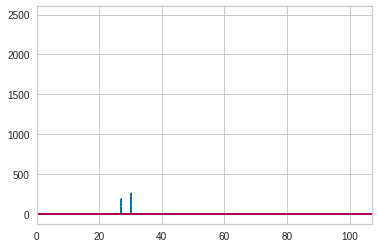

In [ ]:
run_models(metric='Sum',pos='QB',save=True)
run_models(metric='Avg',pos='QB',save=True)

Pulling data
Running Models
Saving Models
Pulling data
Running Models
Saving Models


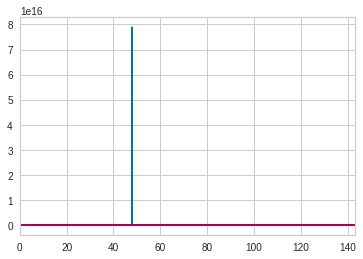

In [6]:
run_models(metric='Sum',pos='RB',save=True)
run_models(metric='Avg',pos='RB',save=True)

Pulling data
Running Models
Saving Models
Pulling data
Running Models
Saving Models


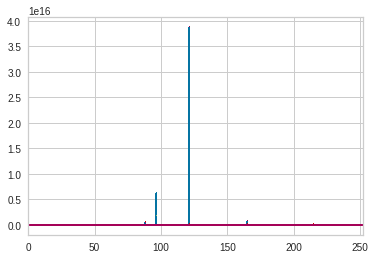

In [ ]:
run_models(metric='Sum',pos='WR',save=True)
run_models(metric='Avg',pos='WR',save=True)

Pulling data
Running Models
Saving Models
Pulling data
Running Models
Saving Models


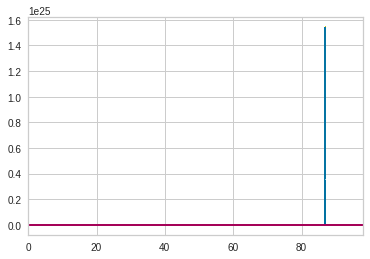

In [ ]:
run_models(metric='Sum',pos='TE',save=True)
run_models(metric='Avg',pos='TE',save=True)

In [ ]:
model_results['Rank'] = model_results.reset_index().index 
model_results['Rank'] = model_results['Rank'] + 1
model_results = model_results.sort_values('y_hat',ascending=False)
model_results['Rank_pred'] = model_results.reset_index().index 
model_results['Rank_pred'] = model_results['Rank_pred'] + 1

# join for Comparison
joined_results = model_results
joined_results['Diff'] = joined_results['Rank'] - joined_results['Rank_pred']
joined_results = joined_results.sort_values('y',ascending=False)
joined_results['rank_metric'] = joined_results.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Rank'] + 1), axis=1)
joined_results['points_metric'] = joined_results.apply(lambda x: np.abs(x['y'] - x['y_hat']) / np.log10(x['Rank'] + 1), axis=1)


rank = np.sum(joined_results['rank_metric'])
median = np.median(joined_results['rank_metric'])
points_median = np.median(joined_results['points_metric'])

In [ ]:
# Make custom scorer
def my_custom_loss_func(y, y_hat):
  model_results = pd.DataFrame()
  model_results['y'] = y
  model_results['y_hat'] = y_hat

  # Pred Rank
  model_results = model_results.sort_values('y_hat', axis=1)
  model_results['Rank_pred'] = model_results.reset_index().index 
  model_results['Rank_pred'] = model_results['Rank_pred'] + 1

  # Actuals
  model_results = model_results.sort_values('y', axis=1)
  model_results['Rank'] = model_results.reset_index().index 
  model_results['Rank'] = model_results['Rank'] + 1

  # join for Comparison
  joined_results = model_results
  joined_results['Diff'] = joined_results['Rank'] - joined_results['Rank_pred']
  joined_results['rank_metric'] = joined_results.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Rank'] + 1), axis=1)

  rank = np.sum(joined_results['rank_metric'])
  return rank

Pulling data
Running Models


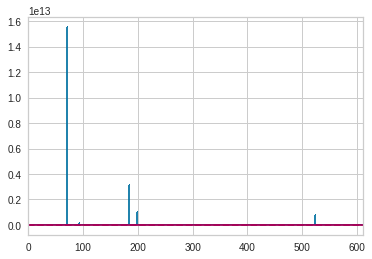

In [ ]:
metric = 'Sum'
pos = 'RB'
save = True

results, preds = run_models(metric=metric,pos=pos, save=save)

# results_name ='{}_{}_model_results_{}.csv'.format(pos, metric, today)
# results.to_csv(str(results_name))
# !cp results.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

# preds_name ='{}_{}_predictions_{}.csv'.format(pos, metric, today)
# preds.to_csv(str(preds_name))
# !cp preds.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

In [ ]:
# results_name ='{}_{}_model_results_{}.csv'.format(pos, metric, today)
# results.to_csv(str(results_name))
# !cp results.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

preds_name ='/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs/{}_{}_predictions_{}.csv'.format(pos, metric, today)
print(preds_name)
preds.to_csv(str(preds_name))
#!cp preds_name "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs/RB_Sum_predictions_2022-04-07.csv


In [ ]:
preds

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat,Rank_pred,Rank,Diff,rank_metric,points_metric
2,True,True,True,rf,Jonathan Taylor,Colts,RB,2021,0,362.0,214.046488,3.0,1.0,-2.0,6.643856,491.490927
7,True,True,True,rf,Austin Ekeler,Chargers,RB,2021,0,331.0,176.394700,8.0,2.0,-6.0,12.575420,324.037755
19,True,True,True,rf,Joe Mixon,Bengals,RB,2021,0,277.0,129.991553,20.0,3.0,-17.0,28.236389,244.175745
24,True,True,True,rf,James Conner,Cardinals,RB,2021,0,247.0,103.961115,25.0,4.0,-21.0,30.044208,204.642380
13,True,True,True,rf,Leonard Fournette,Buccaneers,RB,2021,0,242.0,153.951779,14.0,5.0,-9.0,11.565875,113.150523
18,True,True,True,rf,Ezekiel Elliott,Cowboys,RB,2021,0,241.0,131.819657,19.0,6.0,-13.0,15.382831,129.192517
9,True,True,True,rf,Alvin Kamara,Saints,RB,2021,0,224.0,169.839819,10.0,7.0,-3.0,3.321928,59.972075
23,True,True,True,rf,Antonio Gibson,Football Team,RB,2021,0,220.0,112.492777,24.0,8.0,-16.0,16.767226,112.662370
10,True,True,True,rf,Aaron Jones,Packers,RB,2021,0,218.0,160.342855,11.0,9.0,-2.0,2.000000,57.657145
1,True,True,True,rf,Josh Jacobs,Raiders,RB,2021,0,213.0,229.190344,2.0,10.0,8.0,7.682021,15.546819


In [ ]:
name ='{}_{}_model_results_{}.csv'.format(pos, metric, today)
results.to_csv(str(name))
!cp results.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

Pulling data
Running Models
cp: cannot stat 'sum_rb_preds.csv': No such file or directory


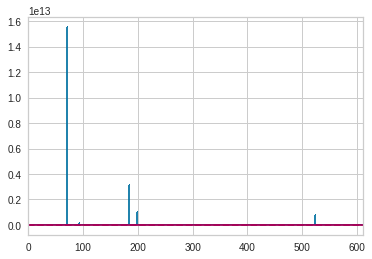

In [ ]:
sum_rb_results, sum_rb_preds = run_models(metric='Sum',pos='RB', save=True)
sum_rb_results.to_csv('sum_rb_results.csv')
!cp -r sum_rb_results.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

sum_rb_preds.to_csv('sum_rb_preds')
!cp -r sum_rb_preds.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

In [ ]:
sum_rb_results.to_csv('sum_rb_results.csv')
!cp sum_rb_results.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

sum_rb_preds.to_csv('sum_rb_preds.csv')
!cp sum_rb_preds.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"

In [ ]:
sum_rb_preds

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat,Rank_pred,Rank,Diff,rank_metric,points_metric
2,True,True,True,rf,Jonathan Taylor,Colts,RB,2021,0,362.0,214.046488,3.0,1.0,-2.0,6.643856,491.490927
8,True,True,True,rf,Austin Ekeler,Chargers,RB,2021,0,331.0,174.562821,9.0,2.0,-7.0,14.671323,327.877195
19,True,True,True,rf,Joe Mixon,Bengals,RB,2021,0,277.0,129.991553,20.0,3.0,-17.0,28.236389,244.175745
24,True,True,True,rf,James Conner,Cardinals,RB,2021,0,247.0,103.961115,25.0,4.0,-21.0,30.044208,204.642380
13,True,True,True,rf,Leonard Fournette,Buccaneers,RB,2021,0,242.0,154.793960,14.0,5.0,-9.0,11.565875,112.068239
18,True,True,True,rf,Ezekiel Elliott,Cowboys,RB,2021,0,241.0,131.819657,19.0,6.0,-13.0,15.382831,129.192517
9,True,True,True,rf,Alvin Kamara,Saints,RB,2021,0,224.0,168.855636,10.0,7.0,-3.0,3.321928,61.061871
23,True,True,True,rf,Antonio Gibson,Football Team,RB,2021,0,220.0,112.492777,24.0,8.0,-16.0,16.767226,112.662370
11,True,True,True,rf,Aaron Jones,Packers,RB,2021,0,218.0,160.342855,12.0,9.0,-3.0,3.000000,57.657145
1,True,True,True,rf,Josh Jacobs,Raiders,RB,2021,0,213.0,229.190344,2.0,10.0,8.0,7.682021,15.546819


In [ ]:
test = pd.DataFrame([['test']])
test

,0
0,test


In [ ]:
test.to_csv('test.csv')
!cp -r test.csv "/content/gdrive/MyDrive/DVA Project/Data/Model_Outputs"


In [ ]:
#final_results = pd.DataFrame(columns=['Boxcox','Model', 'Player','Max_Team_Name','Pos','Current_Year','y','y_hat'])
cutoff_val_list = [0,1,2,4,6]
pca_list = [True, False]
boxcox_list = [True, False]
cooks_list = [True, False]

In [ ]:
def top_50_df(model_results, top_50):
        
    model_results = model_results.sort_values('y_hat',ascending=False)
    model_results['Rank_pred'] = model_results.reset_index().index 
    model_results['Rank_pred'] = model_results['Rank_pred'] + 1
    
    # join for Comparison
    joined_results = model_results.merge(top_50, left_on=['Player','Max_Team_Name','Pos','Current_Year'], right_on=['Player','Max_Team_Name','Pos','Current_Year'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
    joined_results['Diff'] = joined_results['Rank'] - joined_results['Rank_pred']
    joined_results = joined_results.sort_values('y',ascending=False)
    joined_results['rank_metric'] = joined_results.apply(lambda x: np.abs(x['Diff']) / np.log10(x['Rank'] + 1), axis=1)
    joined_results['points_metric'] = joined_results.apply(lambda x: np.abs(x['y'] - x['y_hat']) / np.log10(x['Rank'] + 1), axis=1)

    
    rank_mse_50 = np.mean(joined_results['rank_metric'])
    #mse_50 = mean_squared_error(joined_results['y'], joined_results['y_hat'])
    mse_50 = np.mean(joined_results['points_metric'])


    filtered_results = joined_results.iloc[0:20, :]

    rank_mse_20 = np.mean(filtered_results['metric'])
    #mse_20 = mean_squared_error(filtered_results['y'], filtered_results['y_hat'])
    mse_20 = np.mean(filtered_results['points_metric'])


    return joined_results, rank_mse_50, mse_50, rank_mse_20, mse_20

In [ ]:
final_results = pd.DataFrame(columns=['Cooks', 'Boxcox','PCA', 'Cutoff_Val', 'Model','rank_mse_50','mse_50','rank_mse_20','mse_20', 'test_mse'])
prediction_results = pd.DataFrame(columns = ['Cooks','Boxcox','PCA', 'Model','Player', 'Max_Team_Name', 'Pos', 'Current_Year', 'cutoff_val', 'y', 'y_hat'])

[15:24:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
EN Regression MSE: Cooks: True, Boxcox: True PCA: True Cutoff: 0: Top 20 MSE: 39.402493094382635, Test MSE: 19.423777418520807, R2: -14075540266573.281


RF Regression MSE: Cooks: True, Boxcox:True PCA: True Cutoff: 0: Top 20 MSE: 39.64205339329119, Test MSE: 14.959444103765307, R2: -1421468509144.9177
XGBoost Regression MSE: Cooks: True, Boxcox True PCA: True Cutoff: 0: Top 20 MSE: 49.31781168369376, Test MSE: 16.610738882017493, R2: -770765549444.6895
[15:26:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
EN Regression MSE: Cooks: False, Boxcox: True PCA: True Cutoff: 0: Top 20 MSE: 37.65754742438204, Test MSE: 16.591475177488924, R2: -12615461690912.941


RF Regression MSE: Cooks: False, Boxcox:True PCA: True Cutoff: 0: Top 20 MSE: 40.48548107718476, Test MSE: 15.711425057412958, R2: -22

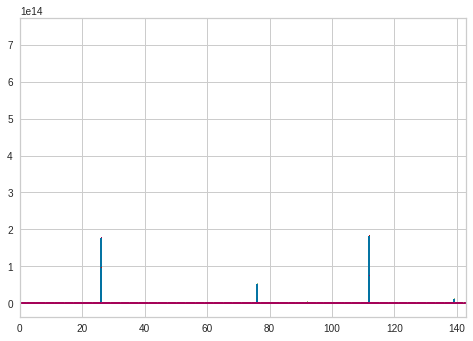

In [ ]:

for cutoff_val in cutoff_val_list:
  for pca_val in pca_list:
    for boxcox_val in boxcox_list:
      for cooks_val in cooks_list:
        model_data = data_full[data_full['Avg_Points'] > cutoff_val]
        model_data = model_data[model_data['Current_Year'] != 2021]
        model_data = model_data[model_data['Current_Year'] != 2022]
        model_data = model_data[model_data['Current_Year'] >= 2013]




        # RB Modeling
        data = model_data.copy()



        if boxcox_val == True:
          # Boxcox transformation
          transformed_data, best_lambda = boxcox(data['Avg_Points']) 
          #sns.distplot(transformed_data, hist=False, kde=True) 
          # Replace Y with transformed data
          data['y'] = transformed_data
        else:
          data['y'] = data['Avg_Points']

        
        data = data.drop(columns='Avg_Points', axis=1)

        # Split into Train and Test
        x_players = data.iloc[:, 0:4]
        x_data = data.iloc[:, 4:-1]
        y_data = data.iloc[:, -1]

        # Fill NA with 0
        x_data = x_data.fillna(0)
            
        # Split Train Test
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=614, shuffle=True)

        # Undo ytest lambda
        if boxcox_val == True:
          y_test = inv_boxcox(y_test, best_lambda)

        # If Cooks
        if cooks_val == True:
          visualizer = CooksDistance()
          visualizer.fit(x_train, y_train)
          #visualizer.show()
          i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
          x_train, y_train = x_train[i_less_influential], y_train[i_less_influential]

        # Scale data
        scaler = StandardScaler() 
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        val_players = val_set.iloc[:, 0:4]
        val_x = val_set.iloc[:, 4:-1]
        val_x = val_x.fillna(0)
        val_y = val_set.iloc[:, -1]

        # Scale val_x
        val_x = scaler.transform(val_x)

        # If PCA
        if pca_val == True:
          pca = PCA(n_components = 15)
          x_train = pca.fit_transform(x_train)
          x_test = pca.transform(x_test)
          val_x = pca.transform(val_x)



        # Try  with CV
        folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

        # Pull out top 50
        top_50 = pd.DataFrame(val_players)
        top_50['cutoff_val'] = cutoff_val
        top_50['y'] = val_y
        top_50 = top_50.sort_values('y',ascending=False).iloc[0:50,:]
        top_50['Rank'] = top_50.reset_index().index
        top_50['Rank'] = top_50['Rank'] + 1


        ############################ Elastic Net
        # define model
        EN = ElasticNet(tol=1e-2)
        # define model evaluation method (used same folds as above for first pass)
        ##EN_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        # define grid
        EN_grid = dict()
        EN_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
        EN_grid['l1_ratio'] = arange(0, 1, 0.01)
        # define search
        try:
            EN_search = GridSearchCV(EN, EN_grid, scoring='neg_mean_absolute_percentage_error', cv=folds, n_jobs=-1)
            # perform the search
            EN_cv_results = EN_search.fit(x_train, y_train)
            # Predict on val
            EN_val_pred = EN_cv_results.predict(val_x)
            EN_test_pred = EN_cv_results.predict(x_test)
            if boxcox_val == True:
              EN_val_pred = inv_boxcox(EN_val_pred, best_lambda)
              EN_test_pred = inv_boxcox(EN_test_pred, best_lambda)
            
            # Final Data
            EN_results = pd.DataFrame(val_players)
            EN_results['Cooks'] = cooks_val
            EN_results['Boxcox'] = boxcox_val
            EN_results['PCA'] = pca_val
            EN_results['Model'] = 'EN'
            EN_results['cutoff_val'] = cutoff_val
            EN_results['y'] = val_y
            EN_results['y_hat'] = EN_val_pred
            EN_results = EN_results[EN_results['y'] > 0].sort_values('y', ascending=False)
            EN_results = EN_results.iloc[0:50,:]
            
            EN_results_joined, EN_rank_mse_50, EN_mse_50, EN_rank_mse_20, EN_mse_20 = top_50_df(EN_results, top_50)

            EN_test_mse =  mean_squared_error(y_test, EN_test_pred)

            EN_r2 = EN_cv_results.best_score_
    
        except:
            pass

        ############################ Random Forest
        random_grid = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt'],
                'max_depth' : [4,5,6,7,8]}


        rf = RandomForestRegressor()

        # define search
        rf_cv = GridSearchCV(estimator=rf, 
                            param_grid=random_grid,
                            cv = folds,
                            scoring='neg_mean_absolute_percentage_error', 
                            n_jobs=-1)
        # perform the search
        rf_cv_results = rf_cv.fit(x_train, y_train)

        rf_val_pred = rf_cv_results.predict(val_x)
        rf_test_pred = rf_cv_results.predict(x_test)
        if boxcox_val == True:
          rf_val_pred = inv_boxcox(rf_val_pred, best_lambda)
          rf_test_pred = inv_boxcox(rf_test_pred, best_lambda)

        rf_results = pd.DataFrame(val_players)
        rf_results['Cooks'] = cooks_val
        rf_results['Boxcox'] = boxcox_val
        rf_results['PCA'] = pca_val
        rf_results['Model'] = 'rf'
        rf_results['cutoff_val'] = cutoff_val
        rf_results['y'] = val_y
        rf_results['y_hat'] = rf_val_pred
        rf_results = rf_results[rf_results['y'] > 0].sort_values('y', ascending=False)
        rf_results = rf_results.iloc[0:50,:]

        #rf_results, rf_mse = top_50_df(rf_results, top_50)
        rf_results_joined, rf_rank_mse_50, rf_mse_50, rf_rank_mse_20, rf_mse_20 = top_50_df(rf_results, top_50)

        # Test MSE
        rf_test_mse =  mean_squared_error(y_test, rf_test_pred)

        rf_r2 = rf_cv_results.best_score_



        ############## XGBoost

        xgbr = xgb.XGBRegressor(seed = 20)
          # define model evaluation method (used same folds as above for first pass)
          ##EN_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
          # define grid
        params = { 'max_depth': [3,6,10],
          'learning_rate': [0.01, 0.05, 0.1],
          'n_estimators': [100, 500, 1000],
          'colsample_bytree': [0.3, 0.7]}
          
          
          # define search
        clf = GridSearchCV(estimator=xgbr, 
                param_grid=params,
                cv = folds,
                scoring='neg_mean_absolute_percentage_error', 
                n_jobs=-1)
          # perform the search
        XG_cv_results = clf.fit(x_train, y_train)
          
        #EN_results = EN_search.fit(x_train, y_train)
          # Predict on val


        XG_val_pred = XG_cv_results.predict(val_x)
        XG_test_pred = XG_cv_results.predict(x_test)
        if boxcox_val == True:
          XG_val_pred = inv_boxcox(XG_val_pred, best_lambda)
          XG_test_pred = inv_boxcox(XG_test_pred, best_lambda)
          

        # Final Data
        XG_results = pd.DataFrame(val_players)
        XG_results['Cooks'] = cooks_val
        XG_results['Boxcox'] = boxcox_val
        XG_results['PCA'] = pca_val
        XG_results['Model'] = 'XG'
        XG_results['cutoff_val'] = cutoff_val
        XG_results['y'] = val_y
        XG_results['y_hat'] = XG_val_pred
        XG_results = XG_results[XG_results['y'] > 0].sort_values('y', ascending=False)
        XG_results = XG_results.iloc[0:50,:]

          
        #XG_results, XG_mse = top_50_df(rf_results, top_50)
        XG_results_joined, XG_rank_mse_50, XG_mse_50, XG_rank_mse_20, XG_mse_20 = top_50_df(XG_results, top_50)

        # Test MSE
        XG_test_mse =  mean_squared_error(y_test, XG_test_pred)
        XG_r2 = XG_cv_results.best_score_


        ######################## Combine Results

        try: 
          EN_data = pd.DataFrame(data=[[cooks_val, boxcox_val, pca_val, cutoff_val, 'EN', EN_rank_mse_50, EN_mse_50, EN_rank_mse_20, EN_mse_20, EN_test_mse]], columns = ['Cooks','Boxcox','PCA', 'Cutoff_Val', 'Model','rank_mse_50','mse_50','rank_mse_20','mse_20', 'test_mse'])
          final_results = pd.concat([final_results, EN_data])
          prediction_results = pd.concat([prediction_results, EN_results_joined])
          print('EN Regression MSE: Cooks: {}, Boxcox: {} PCA: {} Cutoff: {}: Top 20 MSE: {}, Test MSE: {}, R2: {}'.format(cooks_val,boxcox_val, pca_val, cutoff_val, EN_mse_20, EN_test_mse, EN_r2))
        except:
          pass


        XG_data =  pd.DataFrame(data=[[cooks_val, boxcox_val, pca_val, cutoff_val, 'XG', XG_rank_mse_50, XG_mse_50, XG_rank_mse_20, XG_mse_20, XG_test_mse]], columns = ['Cooks','Boxcox','PCA', 'Cutoff_Val', 'Model','rank_mse_50','mse_50','rank_mse_20','mse_20', 'test_mse'])
        RF_data = pd.DataFrame(data=[[cooks_val, boxcox_val, pca_val, cutoff_val, 'RF', rf_mse_50, rf_mse_50, rf_rank_mse_20, rf_mse_20, rf_test_mse]], columns = ['Cooks','Boxcox','PCA', 'Cutoff_Val', 'Model','rank_mse_50','mse_50','rank_mse_20','mse_20', 'test_mse'])


        final_results = pd.concat([final_results, XG_data])
        final_results = pd.concat([final_results, RF_data])

        prediction_results = pd.concat([prediction_results, XG_results_joined])
        prediction_results = pd.concat([prediction_results, rf_results_joined])




        print('\n')
        print('RF Regression MSE: Cooks: {}, Boxcox:{} PCA: {} Cutoff: {}: Top 20 MSE: {}, Test MSE: {}, R2: {}'.format(cooks_val,boxcox_val, pca_val, cutoff_val, rf_mse_20, rf_test_mse, rf_r2))
        print('XGBoost Regression MSE: Cooks: {}, Boxcox {} PCA: {} Cutoff: {}: Top 20 MSE: {}, Test MSE: {}, R2: {}'.format(cooks_val,boxcox_val, pca_val, cutoff_val, XG_mse_20, XG_test_mse, XG_r2))


In [ ]:
x_data = data_full.iloc[:, 4:-1]
importances = [np.round(x,2) for x in rf_cv_results.best_estimator_.feature_importances_]
for idx, val in enumerate(importances):
  if val > 0:
    print(x_data.columns[idx], val)

Avg_FL; year - 3 0.03
Avg_FL; year - 2 0.02
Avg_PPRFantasyPoints; year - 1 0.24
Avg_Rec; year - 2 0.01
Avg_ReceivingYds; year - 1 0.01
Avg_RushingAtt; year - 2 0.01
Avg_RushingAtt; year - 1 0.01
Avg_RushingTD; year - 1 0.03
Avg_RushingYds; year - 2 0.01
Avg_RushingYds; year - 1 0.01
Avg_Tgt; year - 1 0.01
Bad_Games; year - 3 0.01
Bad_Games; year - 2 0.01
Great_Games; year - 1 0.01
PPRFP_prop; year - 1 0.17
RecTD_prop; year - 1 0.01
RecYds_prop; year - 1 0.01
Rec_prop; year - 2 0.01
Rec_prop; year - 1 0.01
RushingTD_prop; year - 1 0.01
Section1_Fpts; year - 2 0.01
Section1_Fpts; year - 1 0.01
Section2_Fpts; year - 1 0.01
Section3_Fpts; year - 1 0.02
Sum_PPRFantasyPoints; year - 1 0.02
Sum_RushingTD; year - 1 0.01
Sum_Tgt; year - 1 0.01
Team_PPRFantasyPoints; year - 1 0.01
Team_Rec; year - 1 0.01
Team_ReceivingTD; year - 2 0.01
Team_ReceivingTD; year - 1 0.01
Team_ReceivingYds; year - 1 0.01
Team_RushingAtt; year - 3 0.01
Team_RushingAtt; year - 2 0.01
Team_RushingAtt; year - 1 0.02
Team

In [ ]:
from google.colab import files
final_results.to_excel('rb_results_avg.xlsx') 
files.download('rb_results_avg.xlsx')

from google.colab import files
prediction_results.to_excel('rb_predictions_avg.xlsx') 
files.download('rb_predictions_avg.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
final_results

,Cooks,Boxcox,PCA,Cutoff_Val,Model,rank_mse_50,mse_50,rank_mse_20,mse_20,test_mse
0,True,True,True,0,EN,150.960000,28.109746,119.75,39.402493,19.423777
0,True,True,True,0,XG,190.520000,33.083306,146.50,49.317812,16.610739
0,True,True,True,0,RF,28.164844,28.164844,148.10,39.642053,14.959444
0,False,True,True,0,EN,148.560000,27.544460,109.00,37.657547,16.591475
0,False,True,True,0,XG,183.640000,35.179037,156.80,52.079067,18.049794
...,...,...,...,...,...,...,...,...,...,...
0,True,False,False,6,XG,230.640000,11.638431,201.80,18.539542,18.940394
0,True,False,False,6,RF,10.163538,10.163538,147.75,16.208476,16.589194
0,False,False,False,6,EN,198.240000,9.738207,163.75,15.630665,14.706627
0,False,False,False,6,XG,220.880000,11.319715,202.05,19.168477,16.671164


In [ ]:
# Best if sort by rank 50
prediction_results.query('Model == "rf" and cutoff_val == 4 and Cooks == False and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

NameError: ignored

In [ ]:
prediction_results.query('Model == "rf" and cutoff_val == 4 and Cooks == False and Boxcox == False and PCA == True').sort_values('y', ascending=False).head(20)

NameError: ignored

In [ ]:
# best if sort by Rank 20
prediction_results.query('Model == "rf" and cutoff_val == 4 and Cooks == False and Boxcox == False and PCA == True').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat,Rank_pred,Rank,Diff
0,False,False,True,rf,Dalvin Cook,Vikings,RB,2021,4,15.230769,17.680627,1.0,10.0,9.0
1,False,False,True,rf,James Robinson,Jaguars,RB,2021,4,11.571429,16.401321,2.0,22.0,20.0
2,False,False,True,rf,Derrick Henry,Titans,RB,2021,4,23.625000,16.311212,3.0,1.0,-2.0
3,False,False,True,rf,Josh Jacobs,Raiders,RB,2021,4,14.200000,15.561794,4.0,14.0,10.0
4,False,False,True,rf,Aaron Jones,Packers,RB,2021,4,14.533333,15.443592,5.0,12.0,7.0
5,False,False,True,rf,Alvin Kamara,Saints,RB,2021,4,17.230769,15.144340,6.0,7.0,1.0
6,False,False,True,rf,Myles Gaskin,Dolphins,RB,2021,4,9.411765,15.057777,7.0,37.0,30.0
7,False,False,True,rf,Jonathan Taylor,Colts,RB,2021,4,21.294118,14.953951,8.0,2.0,-6.0
8,False,False,True,rf,David Montgomery,Bears,RB,2021,4,14.230769,14.467433,9.0,13.0,4.0
9,False,False,True,rf,Nick Chubb,Browns,RB,2021,4,14.571429,14.415574,10.0,11.0,1.0


In [ ]:
# Best so far (sort by mse_20)
prediction_results.query('Model == "rf" and cutoff_val == 0 and Cooks == True and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
1810,True,False,False,rf,Dalvin Cook,Vikings,RB,2021,0,15.230769,17.734844
252,True,False,False,rf,Alvin Kamara,Saints,RB,2021,0,17.230769,17.456429
2367,True,False,False,rf,Derrick Henry,Titans,RB,2021,0,23.625000,14.949539
2885,True,False,False,rf,Ezekiel Elliott,Cowboys,RB,2021,0,14.176471,14.233475
45,True,False,False,rf,Aaron Jones,Packers,RB,2021,0,14.533333,14.231438
4114,True,False,False,rf,Jonathan Taylor,Colts,RB,2021,0,21.294118,14.210274
3467,True,False,False,rf,James Robinson,Jaguars,RB,2021,0,11.571429,14.087706
4303,True,False,False,rf,Josh Jacobs,Raiders,RB,2021,0,14.200000,13.336740
2088,True,False,False,rf,David Montgomery,Bears,RB,2021,0,14.230769,13.127785
5944,True,False,False,rf,Nick Chubb,Browns,RB,2021,0,14.571429,12.601172


In [ ]:
# Second Best (sorting by test error) (accounted more for injury it looks like)
prediction_results.query('Model == "rf" and cutoff_val == 100 and Cooks == False and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
2041,False,False,False,rf,Davante Adams,Packers,WR,2021,100,337.0,248.144046
6956,False,False,False,rf,Stefon Diggs,Bills,WR,2021,100,279.0,246.772553
7657,False,False,False,rf,Tyreek Hill,Chiefs,WR,2021,100,286.0,233.971544
2174,False,False,False,rf,DeAndre Hopkins,Cardinals,WR,2021,100,143.0,228.285622
4450,False,False,False,rf,Justin Jefferson,Vikings,WR,2021,100,321.0,227.007271
1394,False,False,False,rf,Chris Godwin,Buccaneers,WR,2021,100,237.0,222.511347
1640,False,False,False,rf,Cooper Kupp,Rams,WR,2021,100,430.0,222.273659
4543,False,False,False,rf,Keenan Allen,Chargers,WR,2021,100,251.0,219.440961
1760,False,False,False,rf,D.K. Metcalf,Seahawks,WR,2021,100,237.0,217.445921
6507,False,False,False,rf,Robert Woods,Rams,WR,2021,100,131.0,209.986140


In [ ]:
# Second best? lowest of almost all fields
prediction_results.query('Model == "EN" and cutoff_val == 10 and Cooks == True and Boxcox == False and PCA == True').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
2041,True,False,True,EN,Davante Adams,Packers,WR,2021,10,337.0,254.218168
6956,True,False,True,EN,Stefon Diggs,Bills,WR,2021,10,279.0,241.446453
2174,True,False,True,EN,DeAndre Hopkins,Cardinals,WR,2021,10,143.0,215.607241
1,True,False,True,EN,A.J. Brown,Titans,WR,2021,10,174.0,212.835778
4543,True,False,True,EN,Keenan Allen,Chargers,WR,2021,10,251.0,212.686885
7657,True,False,True,EN,Tyreek Hill,Chiefs,WR,2021,10,286.0,211.497341
6507,True,False,True,EN,Robert Woods,Rams,WR,2021,10,131.0,207.065893
1760,True,False,True,EN,D.K. Metcalf,Seahawks,WR,2021,10,237.0,205.661875
7236,True,False,True,EN,Terry McLaurin,Football Team,WR,2021,10,208.0,201.912234
3574,True,False,True,EN,Jarvis Landry,Browns,WR,2021,10,128.0,197.166935


In [ ]:
prediction_results.query('Model == "EN" and cutoff_val == 50 and Cooks == False and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
2174,False,False,False,EN,DeAndre Hopkins,Cardinals,WR,2021,50,143.0,292.829751
2041,False,False,False,EN,Davante Adams,Packers,WR,2021,50,337.0,238.051295
6956,False,False,False,EN,Stefon Diggs,Bills,WR,2021,50,279.0,230.800088
6507,False,False,False,EN,Robert Woods,Rams,WR,2021,50,131.0,218.092587
4543,False,False,False,EN,Keenan Allen,Chargers,WR,2021,50,251.0,212.184930
7657,False,False,False,EN,Tyreek Hill,Chiefs,WR,2021,50,286.0,209.205466
1,False,False,False,EN,A.J. Brown,Titans,WR,2021,50,174.0,201.016952
1640,False,False,False,EN,Cooper Kupp,Rams,WR,2021,50,430.0,199.649740
82,False,False,False,EN,Adam Thielen,Vikings,WR,2021,50,195.0,195.452885
7236,False,False,False,EN,Terry McLaurin,Football Team,WR,2021,50,208.0,191.021738


In [ ]:
prediction_results.query('Model == "EN" and cutoff_val ==1 and Cooks == False and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
1810,False,False,False,EN,Dalvin Cook,Vikings,RB,2021,1,15.230769,20.628811
2367,False,False,False,EN,Derrick Henry,Titans,RB,2021,1,23.625000,20.023477
252,False,False,False,EN,Alvin Kamara,Saints,RB,2021,1,17.230769,19.016868
45,False,False,False,EN,Aaron Jones,Packers,RB,2021,1,14.533333,17.510477
5944,False,False,False,EN,Nick Chubb,Browns,RB,2021,1,14.571429,15.970027
2088,False,False,False,EN,David Montgomery,Bears,RB,2021,1,14.230769,15.618642
4114,False,False,False,EN,Jonathan Taylor,Colts,RB,2021,1,21.294118,14.945088
4303,False,False,False,EN,Josh Jacobs,Raiders,RB,2021,1,14.200000,13.924818
3467,False,False,False,EN,James Robinson,Jaguars,RB,2021,1,11.571429,13.848473
5817,False,False,False,EN,Miles Sanders,Eagles,RB,2021,1,9.166667,13.697284


In [ ]:
# Best so far
prediction_results.query('Model == "rf" and cutoff_val ==0 and Cooks == False and Boxcox == False and PCA == True').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
4114,False,False,True,rf,Jonathan Taylor,Colts,RB,2021,0,21.294118,15.549231
252,False,False,True,rf,Alvin Kamara,Saints,RB,2021,0,17.230769,15.348629
1499,False,False,True,rf,Christian McCaffrey,Panthers,RB,2021,0,17.285714,15.049233
1810,False,False,True,rf,Dalvin Cook,Vikings,RB,2021,0,15.230769,14.991250
2367,False,False,True,rf,Derrick Henry,Titans,RB,2021,0,23.625000,14.064474
3467,False,False,True,rf,James Robinson,Jaguars,RB,2021,0,11.571429,13.966294
2088,False,False,True,rf,David Montgomery,Bears,RB,2021,0,14.230769,12.749634
2885,False,False,True,rf,Ezekiel Elliott,Cowboys,RB,2021,0,14.176471,11.989568
524,False,False,True,rf,Austin Ekeler,Chargers,RB,2021,0,20.687500,11.877026
45,False,False,True,rf,Aaron Jones,Packers,RB,2021,0,14.533333,11.625408


In [ ]:
prediction_results.query('Model == "rf" and cutoff_val ==2 and Cooks == False and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
252,False,False,False,rf,Alvin Kamara,Saints,RB,2021,2,17.230769,17.433838
1810,False,False,False,rf,Dalvin Cook,Vikings,RB,2021,2,15.230769,16.270807
2367,False,False,False,rf,Derrick Henry,Titans,RB,2021,2,23.625000,15.297351
4303,False,False,False,rf,Josh Jacobs,Raiders,RB,2021,2,14.200000,14.899381
3467,False,False,False,rf,James Robinson,Jaguars,RB,2021,2,11.571429,14.641421
4114,False,False,False,rf,Jonathan Taylor,Colts,RB,2021,2,21.294118,14.627493
2088,False,False,False,rf,David Montgomery,Bears,RB,2021,2,14.230769,14.494285
45,False,False,False,rf,Aaron Jones,Packers,RB,2021,2,14.533333,13.149375
5944,False,False,False,rf,Nick Chubb,Browns,RB,2021,2,14.571429,12.916172
2885,False,False,False,rf,Ezekiel Elliott,Cowboys,RB,2021,2,14.176471,12.193517


In [ ]:
prediction_results.query('Model == "rf" and cutoff_val ==2 and Cooks == True and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
1810,True,False,False,rf,Dalvin Cook,Vikings,RB,2021,2,15.230769,17.455454
252,True,False,False,rf,Alvin Kamara,Saints,RB,2021,2,17.230769,16.734926
3467,True,False,False,rf,James Robinson,Jaguars,RB,2021,2,11.571429,15.508701
2367,True,False,False,rf,Derrick Henry,Titans,RB,2021,2,23.625000,15.198664
45,True,False,False,rf,Aaron Jones,Packers,RB,2021,2,14.533333,15.002130
4303,True,False,False,rf,Josh Jacobs,Raiders,RB,2021,2,14.200000,14.774268
2088,True,False,False,rf,David Montgomery,Bears,RB,2021,2,14.230769,14.507078
2885,True,False,False,rf,Ezekiel Elliott,Cowboys,RB,2021,2,14.176471,14.330560
4114,True,False,False,rf,Jonathan Taylor,Colts,RB,2021,2,21.294118,14.246955
5583,True,False,False,rf,Melvin Gordon,Broncos,RB,2021,2,11.687500,12.896546


In [ ]:
final_results

,Cooks,Boxcox,PCA,Cutoff_Val,Model,rank_mse_50,mse_50,rank_mse_20,mse_20,test_mse
0,True,True,True,0,EN,134.200000,24.485692,101.00,23.091728,30.623608
0,True,True,True,0,XG,171.440000,31.068128,146.95,27.650914,18.125651
0,True,True,True,0,RF,34.043934,34.043934,141.30,39.207097,14.742234
0,False,True,True,0,EN,147.880000,25.609411,135.60,17.814647,21.444553
0,False,True,True,0,XG,164.160000,32.018368,73.00,32.255410,16.206388
...,...,...,...,...,...,...,...,...,...,...
0,True,False,False,2,XG,195.320000,16.750834,213.75,17.495054,15.153676
0,True,False,False,2,RF,15.100906,15.100906,117.05,11.646433,14.348827
0,False,False,False,2,EN,216.040000,17.133855,181.65,13.026465,15.333628
0,False,False,False,2,XG,236.000000,18.086960,231.40,9.466254,16.534859


In [ ]:
prediction_results

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
2367,True,True,True,EN,Derrick Henry,Titans,RB,2021,0,23.625000,23.432810
4114,True,True,True,EN,Jonathan Taylor,Colts,RB,2021,0,21.294118,12.472706
524,True,True,True,EN,Austin Ekeler,Chargers,RB,2021,0,20.687500,15.656340
3951,True,True,True,EN,Joe Mixon,Bengals,RB,2021,0,17.312500,9.994157
5031,True,True,True,EN,Leonard Fournette,Buccaneers,RB,2021,0,17.285714,10.742944
...,...,...,...,...,...,...,...,...,...,...,...
1765,False,False,False,rf,D'Ernest Johnson,Browns,RB,2021,2,7.833333,5.413408
4677,False,False,False,rf,Kenyan Drake,Raiders,RB,2021,2,7.750000,10.792437
5716,False,False,False,rf,Mike Davis,Falcons,RB,2021,2,7.647059,10.488163
6346,False,False,False,rf,Rex Burkhead,Texans,RB,2021,2,7.384615,7.912339


In [ ]:
from google.colab import files
final_results.to_excel('model_comparison.xlsx') 
files.download('model_comparison.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
prediction_results.to_excel('model_comparison.xlsx') 
files.download('model_comparison.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Scale the final_results to create weighted version

final_results_copy = final_results.copy()

from sklearn.preprocessing import minmax_scale

final_results_copy[['rank_mse_50',	'mse_50',	'rank_mse_20',	'mse_20',	'test_mse']] = minmax_scale(final_results_copy[['rank_mse_50',	'mse_50',	'rank_mse_20',	'mse_20',	'test_mse']])

In [ ]:
final_results_copy['Score'] = (final_results_copy['rank_mse_50'] * 0.2) + (final_results_copy['mse_50'] * 0.1) + (final_results_copy['rank_mse_20'] * 0.25) + (final_results_copy['mse_20'] * 0.15) + (final_results_copy['test_mse'] * 0.2)


In [ ]:
final_results_copy.sort_values('Score').head(10)

,Cooks,Boxcox,PCA,Cutoff_Val,Model,rank_mse_50,mse_50,rank_mse_20,mse_20,test_mse,Score
0,True,False,False,2,RF,0.001880,0.021467,0.277830,0.060566,0.023875,0.085840
0,True,False,False,1,RF,0.005551,0.063389,0.228004,0.170129,0.031880,0.096345
0,False,False,True,0,RF,0.027419,0.313097,0.086093,0.264900,0.047905,0.107633
0,False,False,False,0,RF,0.013523,0.154414,0.282876,0.125738,0.029990,0.113724
0,False,False,False,2,RF,0.000000,0.000000,0.421318,0.178769,0.019607,0.136066
0,True,False,False,1,EN,0.534058,0.042578,0.183854,0.036382,0.002590,0.163008
0,False,False,False,1,EN,0.607980,0.100908,0.104068,0.088721,0.000000,0.171012
0,False,False,False,1,RF,0.013822,0.157832,0.576474,0.006114,0.043667,0.172317
0,True,False,False,0,EN,0.537673,0.144790,0.151056,0.131407,0.049988,0.189486
0,False,False,False,0,EN,0.664912,0.155787,0.134342,0.114640,0.034161,0.206175


In [ ]:
prediction_results.query('Model == "rf" and cutoff_val ==2 and Cooks == True and Boxcox == False and PCA == False').sort_values('y_hat', ascending=False).head(20)

,Cooks,Boxcox,PCA,Model,Player,Max_Team_Name,Pos,Current_Year,cutoff_val,y,y_hat
1810,True,False,False,rf,Dalvin Cook,Vikings,RB,2021,2,15.230769,17.455454
252,True,False,False,rf,Alvin Kamara,Saints,RB,2021,2,17.230769,16.734926
3467,True,False,False,rf,James Robinson,Jaguars,RB,2021,2,11.571429,15.508701
2367,True,False,False,rf,Derrick Henry,Titans,RB,2021,2,23.625000,15.198664
45,True,False,False,rf,Aaron Jones,Packers,RB,2021,2,14.533333,15.002130
4303,True,False,False,rf,Josh Jacobs,Raiders,RB,2021,2,14.200000,14.774268
2088,True,False,False,rf,David Montgomery,Bears,RB,2021,2,14.230769,14.507078
2885,True,False,False,rf,Ezekiel Elliott,Cowboys,RB,2021,2,14.176471,14.330560
4114,True,False,False,rf,Jonathan Taylor,Colts,RB,2021,2,21.294118,14.246955
5583,True,False,False,rf,Melvin Gordon,Broncos,RB,2021,2,11.687500,12.896546


In [ ]:

for cutoff_val in cutoff_val_list:
    model_data = data_full[data_full['Avg_Points'] > cutoff_val]
    model_data = model_data[model_data['Current_Year'] != 2021]
    model_data = model_data[model_data['Current_Year'] != 2022]
    
    
    
    
    # RB Modeling
    data = model_data.copy()
    data = data[data['Pos'] == 'RB']
    
    
    
    # Boxcox transformation
    #transformed_data, best_lambda = boxcox(data['Avg_Points']) 
    #sns.distplot(transformed_data, hist=False, kde=True) 
    
    # Replace Y with transformed data
    #data['y'] = transformed_data
    #data = data.drop(columns='Avg_Points', axis=1)

    data['y'] = data['Avg_Points']
    data = data.drop(columns='Avg_Points', axis=1)
    
    # Split into Train and Test
    x_players = data.iloc[:, 0:4]
    x_data = data.iloc[:, 4:-1]
    y_data = data.iloc[:, -1]
    
    # Fill NA with 0
    x_data = x_data.fillna(0)
        
    # Split Train Test
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=614, shuffle=True)
    
    # Scale data
    scaler = StandardScaler() 
    scaled_x_train = scaler.fit_transform(x_train)
    scaled_x_test = scaler.transform(x_test)
    
    val_players = val_set.iloc[:, 0:4]
    val_x = val_set.iloc[:, 4:-1]
    val_x = val_x.fillna(0)
    val_y = val_set.iloc[:, -1]
    
    # Scale val_x
    scaled_val_x = scaler.transform(val_x)
    
    
    # Try  with CV
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    
    
    ############################ Elastic Net
    # define model
    EN = ElasticNet(tol=1e-2)
    # define model evaluation method (used same folds as above for first pass)
    ##EN_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    EN_grid = dict()
    EN_grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
    EN_grid['l1_ratio'] = arange(0, 1, 0.01)
    # define search
    try:
        EN_search = GridSearchCV(EN, EN_grid, scoring='neg_mean_squared_error', cv=folds, n_jobs=-1)
        # perform the search
        EN_cv_results = EN_search.fit(x_train, y_train)
        # Predict on val
        EN_val_pred = EN_cv_results.predict(val_x)
        #EN_val_pred = inv_boxcox(EN_val_pred, best_lambda)
        
        # Final Data
        EN_results = pd.DataFrame(val_players)
        EN_results['Boxcox'] = 'No'
        EN_results['Model'] = 'EN'
        EN_results['cutoff_val'] = cutoff_val
        EN_results['y'] = val_y
        EN_results['y_hat'] = EN_val_pred
        EN_results = EN_results[EN_results['y'] > 0].sort_values('y', ascending=False)
        EN_results = EN_results.iloc[0:50,:]
        
        EN_results, EN_mse = top_50_df(EN_results, top_50)
    except:
        pass
    
    ############################ Random Forest
    random_grid = {'n_estimators': [200, 500],
            'max_features': ['auto', 'sqrt'],
            'max_depth' : [4,5,6,7,8]}
    
    
    rf = RandomForestRegressor()
    
    # define search
    rf_cv = GridSearchCV(estimator=rf, 
                       param_grid=random_grid,
                       cv = folds,
                       scoring='neg_mean_squared_error', 
                       n_jobs=-1)
    # perform the search
    rf_cv_results = rf_cv.fit(x_train, y_train)
    
    rf_val_pred = rf_cv_results.predict(val_x)
    #rf_val_pred = inv_boxcox(rf_val_pred, best_lambda)
    
    
    rf_results = pd.DataFrame(val_players)
    rf_results['Boxcox'] = 'No'
    rf_results['Model'] = 'rf'
    rf_results['cutoff_val'] = cutoff_val
    rf_results['y'] = val_y
    rf_results['y_hat'] = rf_val_pred
    rf_results = rf_results[rf_results['y'] > 0].sort_values('y', ascending=False)
    rf_results = rf_results.iloc[0:50,:]
    
    rf_results, rf_mse = top_50_df(rf_results, top_50)
    
    ############## XGBoost
    
    xgbr = xgb.XGBRegressor(seed = 20)
     # define model evaluation method (used same folds as above for first pass)
     ##EN_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
     # define grid
    params = { 'max_depth': [3,6,10],
      'learning_rate': [0.01, 0.05, 0.1],
      'n_estimators': [100, 500, 1000],
      'colsample_bytree': [0.3, 0.7]}
     
     
     # define search
    clf = GridSearchCV(estimator=xgbr, 
            param_grid=params,
            cv = folds,
            scoring='neg_mean_squared_error', 
            n_jobs=-1)
     # perform the search
    XG_cv_results = clf.fit(x_train, y_train)
     
    #EN_results = EN_search.fit(x_train, y_train)
     # Predict on val
    XG_val_pred = XG_cv_results.predict(val_x)
    #XG_val_pred = inv_boxcox(XG_val_pred, best_lambda)
     
    
    # Final Data
    XG_results = pd.DataFrame(val_players)
    XG_results['Boxcox'] = 'No'
    XG_results['Model'] = 'XG'
    XG_results['cutoff_val'] = cutoff_val
    XG_results['y'] = val_y
    XG_results['y_hat'] = XG_val_pred
    XG_results = XG_results[XG_results['y'] > 0].sort_values('y', ascending=False)
    XG_results = XG_results.iloc[0:50,:]
    
     
    XG_results, XG_mse = top_50_df(rf_results, top_50)
    
    
    ######################## Combine Results
    
    final_results = pd.concat([final_results, rf_results])
    final_results = pd.concat([final_results, XG_results])
    final_results = pd.concat([final_results, EN_results])

    
    print('\nVal Set Results 2021:')
    print('RF Regression MSE: {}: {}'.format(cutoff_val, rf_mse))
    print('XGBoost Regression MSE: {}: {}'.format(cutoff_val, XG_mse))
    print('EN Regression MSE: {}: {}'.format(cutoff_val, EN_mse))

[03:16:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Val Set Results 2021:
RF Regression MSE: 0: 157.12
XGBoost Regression MSE: 0: 157.12
EN Regression MSE: 0: 161.84
[03:24:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Val Set Results 2021:
RF Regression MSE: 1: 168.52
XGBoost Regression MSE: 1: 168.52
EN Regression MSE: 1: 149.24
[03:31:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Val Set Results 2021:
RF Regression MSE: 2: 156.12
XGBoost Regression MSE: 2: 156.12
EN Regression MSE: 2: 216.04


In [ ]:
final_results.query('Model == "EN" and cutoff_val == 1 and Boxcox == "No"').sort_values('y_hat', ascending=False).head(15)

,Boxcox,Model,Player,Max_Team_Name,Pos,Current_Year,y,y_hat,cutoff_val,Rank_pred,Rank,Diff
0,No,EN,Dalvin Cook,Vikings,RB,2021,15.230769,20.628811,1.0,1.0,10.0,9.0
1,No,EN,Derrick Henry,Titans,RB,2021,23.625000,20.023477,1.0,2.0,1.0,-1.0
2,No,EN,Alvin Kamara,Saints,RB,2021,17.230769,19.016868,1.0,3.0,7.0,4.0
3,No,EN,Aaron Jones,Packers,RB,2021,14.533333,17.510477,1.0,4.0,12.0,8.0
4,No,EN,Nick Chubb,Browns,RB,2021,14.571429,15.970027,1.0,5.0,11.0,6.0
5,No,EN,David Montgomery,Bears,RB,2021,14.230769,15.618642,1.0,6.0,13.0,7.0
6,No,EN,Jonathan Taylor,Colts,RB,2021,21.294118,14.945088,1.0,7.0,2.0,-5.0
7,No,EN,Josh Jacobs,Raiders,RB,2021,14.200000,13.924818,1.0,8.0,14.0,6.0
8,No,EN,James Robinson,Jaguars,RB,2021,11.571429,13.848473,1.0,9.0,22.0,13.0
9,No,EN,Miles Sanders,Eagles,RB,2021,9.166667,13.697284,1.0,10.0,38.0,28.0


In [ ]:
final_results.query('Model == "EN" and cutoff_val == 1 and Boxcox == "Yes"').sort_values('y_hat', ascending=False).head(15)

,Boxcox,Model,Player,Max_Team_Name,Pos,Current_Year,y,y_hat,cutoff_val,Rank_pred,Rank,Diff
0,Yes,EN,Derrick Henry,Titans,RB,2021,23.625000,23.012087,1.0,1.0,1.0,0.0
1,Yes,EN,Dalvin Cook,Vikings,RB,2021,15.230769,22.437127,1.0,2.0,10.0,8.0
2,Yes,EN,David Montgomery,Bears,RB,2021,14.230769,16.138260,1.0,3.0,13.0,10.0
3,Yes,EN,Aaron Jones,Packers,RB,2021,14.533333,15.226536,1.0,4.0,12.0,8.0
4,Yes,EN,Alvin Kamara,Saints,RB,2021,17.230769,14.871152,1.0,5.0,7.0,2.0
5,Yes,EN,Josh Jacobs,Raiders,RB,2021,14.200000,14.408338,1.0,6.0,14.0,8.0
6,Yes,EN,Ezekiel Elliott,Cowboys,RB,2021,14.176471,13.376687,1.0,7.0,15.0,8.0
7,Yes,EN,Nick Chubb,Browns,RB,2021,14.571429,12.859186,1.0,8.0,11.0,3.0
8,Yes,EN,Jonathan Taylor,Colts,RB,2021,21.294118,12.660381,1.0,9.0,2.0,-7.0
9,Yes,EN,Miles Sanders,Eagles,RB,2021,9.166667,12.443570,1.0,10.0,38.0,28.0


In [ ]:
final_results.query('Model == "EN" and cutoff_val == 2 and Boxcox == "Yes"').sort_values('y_hat', ascending=False).head(15)

,Boxcox,Model,Player,Max_Team_Name,Pos,Current_Year,y,y_hat,cutoff_val,Rank_pred,Rank,Diff
0,Yes,EN,Dalvin Cook,Vikings,RB,2021,15.230769,24.103532,2.0,1.0,10.0,9.0
1,Yes,EN,Derrick Henry,Titans,RB,2021,23.625000,23.459236,2.0,2.0,1.0,-1.0
2,Yes,EN,Alvin Kamara,Saints,RB,2021,17.230769,17.346802,2.0,3.0,7.0,4.0
3,Yes,EN,Aaron Jones,Packers,RB,2021,14.533333,16.329525,2.0,4.0,12.0,8.0
4,Yes,EN,David Montgomery,Bears,RB,2021,14.230769,15.046771,2.0,5.0,13.0,8.0
5,Yes,EN,Jonathan Taylor,Colts,RB,2021,21.294118,14.702899,2.0,6.0,2.0,-4.0
6,Yes,EN,James Robinson,Jaguars,RB,2021,11.571429,13.740066,2.0,7.0,22.0,15.0
7,Yes,EN,Josh Jacobs,Raiders,RB,2021,14.200000,13.553722,2.0,8.0,14.0,6.0
8,Yes,EN,Nick Chubb,Browns,RB,2021,14.571429,13.254276,2.0,9.0,11.0,2.0
9,Yes,EN,Miles Sanders,Eagles,RB,2021,9.166667,12.405550,2.0,10.0,38.0,28.0


In [ ]:
final_results.query('Model == "rf" and cutoff_val == 1 and Boxcox == "No"').sort_values('y_hat', ascending=False).head(15)

,Boxcox,Model,Player,Max_Team_Name,Pos,Current_Year,y,y_hat,cutoff_val,Rank_pred,Rank,Diff
0,No,rf,Alvin Kamara,Saints,RB,2021,17.230769,20.573630,1.0,1.0,7.0,6.0
1,No,rf,Derrick Henry,Titans,RB,2021,23.625000,20.110711,1.0,2.0,1.0,-1.0
2,No,rf,Dalvin Cook,Vikings,RB,2021,15.230769,19.491575,1.0,3.0,10.0,7.0
3,No,rf,Josh Jacobs,Raiders,RB,2021,14.200000,15.333102,1.0,4.0,14.0,10.0
4,No,rf,Nick Chubb,Browns,RB,2021,14.571429,15.043206,1.0,5.0,11.0,6.0
5,No,rf,Jonathan Taylor,Colts,RB,2021,21.294118,13.910059,1.0,6.0,2.0,-4.0
6,No,rf,Christian McCaffrey,Panthers,RB,2021,17.285714,13.677077,1.0,7.0,6.0,-1.0
7,No,rf,David Montgomery,Bears,RB,2021,14.230769,13.494553,1.0,8.0,13.0,5.0
8,No,rf,Chris Carson,Seahawks,RB,2021,12.000000,13.419656,1.0,9.0,20.0,11.0
9,No,rf,Ezekiel Elliott,Cowboys,RB,2021,14.176471,13.313365,1.0,10.0,15.0,5.0


In [ ]:
final_results.query('Model == "rf" and cutoff_val == 1 and Boxcox == "Yes"').sort_values('y_hat', ascending=False).head(15)

,Boxcox,Model,Player,Max_Team_Name,Pos,Current_Year,y,y_hat,cutoff_val,Rank_pred,Rank,Diff
0,Yes,rf,Dalvin Cook,Vikings,RB,2021,15.230769,18.604337,1.0,1.0,10.0,9.0
1,Yes,rf,Derrick Henry,Titans,RB,2021,23.625000,18.526186,1.0,2.0,1.0,-1.0
0,Yes,rf,Derrick Henry,Titans,RB,2021,23.625000,18.484091,1.0,1.0,1.0,0.0
1,Yes,rf,Dalvin Cook,Vikings,RB,2021,15.230769,18.235070,1.0,2.0,10.0,8.0
2,Yes,rf,Alvin Kamara,Saints,RB,2021,17.230769,17.858553,1.0,3.0,7.0,4.0
2,Yes,rf,Alvin Kamara,Saints,RB,2021,17.230769,17.441172,1.0,3.0,7.0,4.0
3,Yes,rf,Josh Jacobs,Raiders,RB,2021,14.200000,14.519463,1.0,4.0,14.0,10.0
3,Yes,rf,Josh Jacobs,Raiders,RB,2021,14.200000,14.305140,1.0,4.0,14.0,10.0
4,Yes,rf,Jonathan Taylor,Colts,RB,2021,21.294118,13.943624,1.0,5.0,2.0,-3.0
4,Yes,rf,Jonathan Taylor,Colts,RB,2021,21.294118,13.935727,1.0,5.0,2.0,-3.0


In [ ]:
final_results = final_results.drop_duplicates()

In [ ]:
# Create Comparison DF
final_save = final_results.copy()
final_results['diff'] = final_results['y'] - final_results['y_hat']

final_results.head()




,Boxcox,Model,Player,Max_Team_Name,Pos,Current_Year,y,y_hat,cutoff_val,diff
2367,Yes,rf,Derrick Henry,Titans,RB,2021,23.625000,14.742255,0.0,8.882745
4114,Yes,rf,Jonathan Taylor,Colts,RB,2021,21.294118,12.836641,0.0,8.457477
524,Yes,rf,Austin Ekeler,Chargers,RB,2021,20.687500,10.309118,0.0,10.378382
3951,Yes,rf,Joe Mixon,Bengals,RB,2021,17.312500,8.498077,0.0,8.814423
5031,Yes,rf,Leonard Fournette,Buccaneers,RB,2021,17.285714,8.635030,0.0,8.650684


In [ ]:
final_results = final_results.drop(columns={'y_hat'})
final_results.head()
#prod_rb.merge(rb_EN_results_2022, left_on=['Player','Current_Year','Pos', 'Max_Team_Name'], right_on=['Player','Current_Year','Pos', 'Max_Team_Name'], how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

,Boxcox,Model,Player,Max_Team_Name,Pos,Current_Year,y,cutoff_val,diff
2367,Yes,rf,Derrick Henry,Titans,RB,2021,23.625000,0.0,8.882745
4114,Yes,rf,Jonathan Taylor,Colts,RB,2021,21.294118,0.0,8.457477
524,Yes,rf,Austin Ekeler,Chargers,RB,2021,20.687500,0.0,10.378382
3951,Yes,rf,Joe Mixon,Bengals,RB,2021,17.312500,0.0,8.814423
5031,Yes,rf,Leonard Fournette,Buccaneers,RB,2021,17.285714,0.0,8.650684


In [ ]:
pivot_data = pd.pivot_table(final_results, index=['Player','Pos','Max_Team_Name','Current_Year','y'], columns=['Boxcox','Model','cutoff_val'], values='diff').reset_index()
pivot_data.columns = ['Player','Pos','Team_Name','Year','y','Norm_EN_0','Norm_EN_1','Norm_EN_2', 'Norm_XG_0', 'Norm_XG_1','Norm_XG_2','Norm_RF_0','Norm_RF_1','Norm_RF_2', \
'Boxcox_EN_0','Boxcox_EN_1','Boxcox_EN_2', 'Boxcox_XG_0', 'Boxcox_XG_1','Boxcox_XG_2','Boxcox_RF_0','Boxcox_RF_1','Boxcox_RF_2']
pivot_data = pivot_data.sort_values('y', ascending=False)
pivot_data.head()

,Player,Pos,Team_Name,Year,y,Norm_EN_0,Norm_EN_1,Norm_EN_2,Norm_XG_0,Norm_XG_1,...,Norm_RF_2,Boxcox_EN_0,Boxcox_EN_1,Boxcox_EN_2,Boxcox_XG_0,Boxcox_XG_1,Boxcox_XG_2,Boxcox_RF_0,Boxcox_RF_1,Boxcox_RF_2
19,Derrick Henry,RB,Titans,2021,23.625000,2.443713,3.601523,6.543910,6.919466,7.163498,...,7.762910,2.902408,0.612913,0.165764,5.732939,6.459501,7.552011,8.882745,5.016795,8.577654
33,Jonathan Taylor,RB,Colts,2021,21.294118,6.941731,6.349030,6.447762,5.324877,6.996994,...,6.363047,9.336545,8.633736,6.591218,5.420826,5.344441,6.954804,8.457477,7.772670,7.704633
5,Austin Ekeler,RB,Chargers,2021,20.687500,8.195138,8.866285,9.733258,9.806792,10.240299,...,9.268759,11.596715,10.293690,11.022061,7.858711,9.769063,11.689445,10.378382,10.570800,11.822624
32,Joe Mixon,RB,Bengals,2021,17.312500,9.635297,9.170717,10.014928,8.311198,7.517765,...,8.540671,10.171001,10.313205,11.061804,7.096864,8.227563,10.085169,8.814423,9.369292,9.643487
38,Leonard Fournette,RB,Buccaneers,2021,17.285714,7.178560,7.494130,8.914433,10.019549,8.314847,...,8.359434,9.482298,9.235437,10.172814,9.203428,9.671818,7.753781,8.650684,8.874541,9.178972


In [ ]:
from google.colab import files
pivot_data.to_excel('pivot_data.xlsx') 
files.download('pivot_data.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>